# Dependencies

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import plotly.graph_objs as go
from plotly.offline import iplot
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load Dataframe

In [3]:
# Load dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,176,L47355,L,298.2,308.1,1382,43.5,37,0,No Failure
1,1177,M16036,M,297.2,308.3,1429,42.0,6,0,No Failure
2,6683,L53862,L,301.5,310.8,1512,38.9,9,0,No Failure
3,2961,L50140,L,300.7,309.5,1467,44.3,55,0,No Failure
4,1677,H31090,H,297.9,307.6,1418,43.0,207,0,No Failure


# EDA & Preprocessing

In [5]:
# Size of Dataset
R = df.shape[0]
C = df.shape[1]
print(f"Number of rows: {R}")
print(f"Number of columns: {C}")

Number of rows: 10000
Number of columns: 10


In [6]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [7]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [8]:
# Drop unnecessary columns
df = df.drop(['UDI'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Product ID'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Target'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Failure Type'],
      dtype='object')

In [9]:
# Drop duplicated rows
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0


In [10]:
df["Type"].value_counts()

,count
Type,
L,6000
M,2997
H,1003


In [11]:
df["Failure Type"].value_counts()

,count
Failure Type,
No Failure,9652
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
Random Failures,18


In [12]:
# Show categorical columns
categorical_cols = list(set(df.columns.to_list()) - set(df._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['Failure Type', 'Type']


In [13]:
# Encode ordinal data

enc_maps = {
    "Type" : [{'col': "Type", 'mapping': {"L": 0, "M": 1, "H": 2}}],
    "Failure Type" : [{'col': "Failure Type", 'mapping': {
        "No Failure": 0,
        "Heat Dissipation Failure": 1,
        "Power Failure": 2,
        "Overstrain Failure": 3,
        "Tool Wear Failure": 4,
        "Random Failures": 5,
        }}],
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df = enc.fit_transform(df)

df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,0,298.2,308.1,1382,43.5,37,0
1,1,297.2,308.3,1429,42.0,6,0
2,0,301.5,310.8,1512,38.9,9,0
3,0,300.7,309.5,1467,44.3,55,0
4,2,297.9,307.6,1418,43.0,207,0


<Axes: >

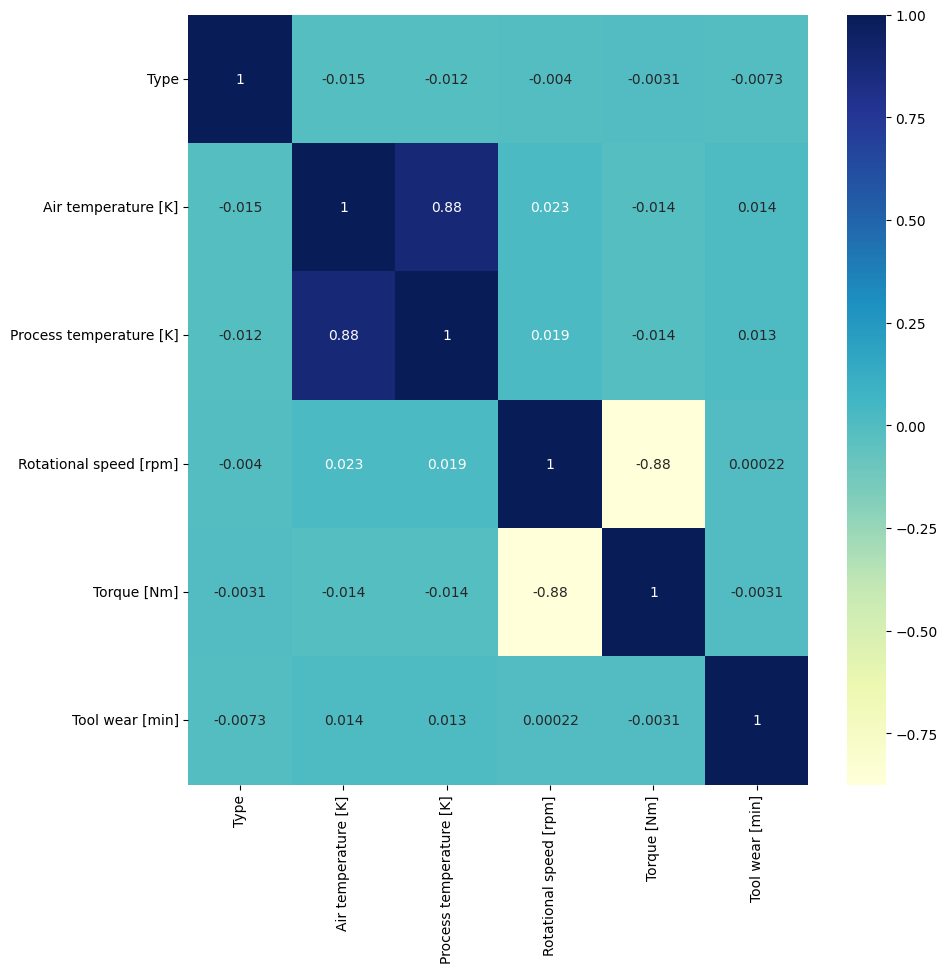

In [14]:
# Displaying heatmap
X = df.drop(['Failure Type'], axis=1)

plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr(method="pearson"), cmap="YlGnBu", annot=True)

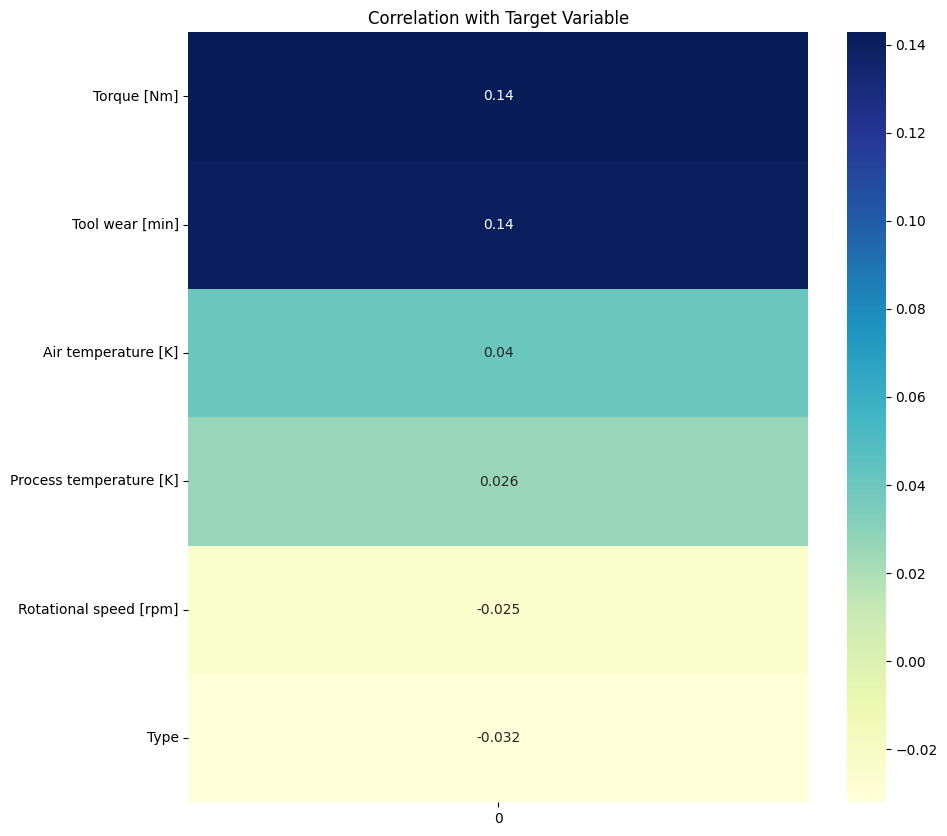

In [15]:
# Create a correlation matrix with target variable
y = df['Failure Type']

corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_with_target.to_frame(), cmap='YlGnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

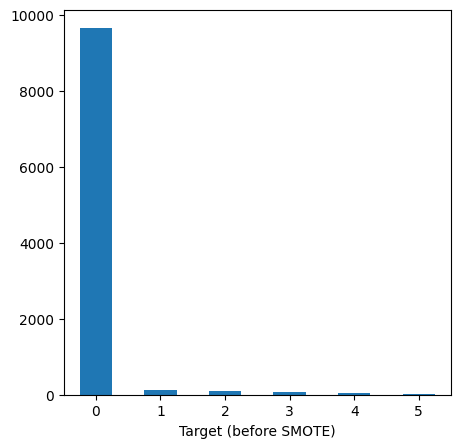

In [16]:
ax = df["Failure Type"].value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target (before SMOTE)')
plt.xticks(rotation=0)
plt.show()

In [17]:
print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 9652, 1: 112, 2: 95, 3: 78, 4: 45, 5: 18})


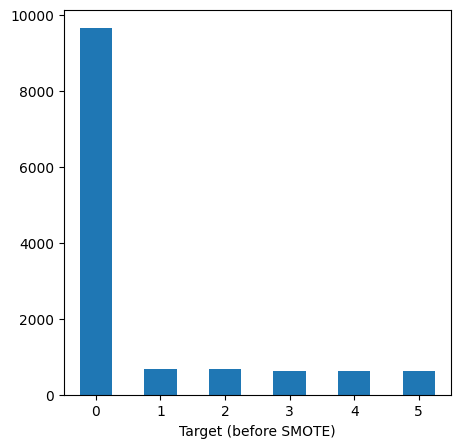

In [18]:
# Oversampling

sampling_strategy = {
    0: 9652,
    1: 672,
    2: 665,
    3: 624,
    4: 630,
    5: 630,
    }
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X, y = smote.fit_resample(X, y)
X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y)

ax = y.value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target (before SMOTE)')
plt.xticks(rotation=0)
plt.show()

In [19]:
print("After SMOTE:", Counter(y))

After SMOTE: Counter({0: 9652, 1: 672, 2: 665, 4: 630, 5: 630, 3: 624})


# Data Splitting

In [20]:
# Train/Val/Test: 80/10/10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

# Modelling

In [21]:
def evaluate_model(model, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    cm = multilabel_confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in y.unique()])
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()
    print("Training acc score:", accuracy_score(y_train, y_train_pred))
    print("Training null acc:", y_train.value_counts().max() / len(y_train))
    print()
    print("Testing acc score:", accuracy_score(y_test, y_pred))
    print("Testing null acc:", y_test.value_counts().max() / len(y_test))
    print()
    print(classification_report(y_pred,y_test))

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = []
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []
max_idx = -1

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    print(f"{np.sum(y[val_idx] == 0)} out of {len(val_idx)}")
    print(f"{np.sum(y[val_idx] == 1)} out of {len(val_idx)}")
    print(f"{np.sum(y[val_idx] == 2)} out of {len(val_idx)}")
    print(f"{np.sum(y[val_idx] == 3)} out of {len(val_idx)}")
    print(f"{np.sum(y[val_idx] == 4)} out of {len(val_idx)}")
    print(f"{np.sum(y[val_idx] == 5)} out of {len(val_idx)}")
    print()

    X_train_list.append(X_train)
    X_val_list.append(X_val)
    y_train_list.append(y_train)
    y_val_list.append(y_val)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    stratified_scores.append(accuracy_score(y_val, y_pred))

max_idx = np.argmax(stratified_scores)

print(f"Stratified K-Fold scores: {stratified_scores}")
print(f"Mean: {np.mean(stratified_scores):.5f}, Std: {np.std(stratified_scores):.5f}")
print(f"Argmax: {max_idx}")

1931 out of 2575
134 out of 2575
133 out of 2575
125 out of 2575
126 out of 2575
126 out of 2575

1931 out of 2575
134 out of 2575
133 out of 2575
125 out of 2575
126 out of 2575
126 out of 2575

1930 out of 2575
135 out of 2575
133 out of 2575
125 out of 2575
126 out of 2575
126 out of 2575

1930 out of 2574
135 out of 2574
133 out of 2574
124 out of 2574
126 out of 2574
126 out of 2574

1930 out of 2574
134 out of 2574
133 out of 2574
125 out of 2574
126 out of 2574
126 out of 2574

Stratified K-Fold scores: [0.9654368932038835, 0.9693203883495146, 0.967378640776699, 0.9685314685314685, 0.9677544677544677]
Mean: 0.96768, Std: 0.00131
Argmax: 1


In [23]:
model = RandomForestClassifier(random_state=42)
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [24]:
X_train, X_val, y_train, y_val = X_train_list[max_idx], X_val_list[max_idx], y_train_list[max_idx], y_val_list[max_idx]

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

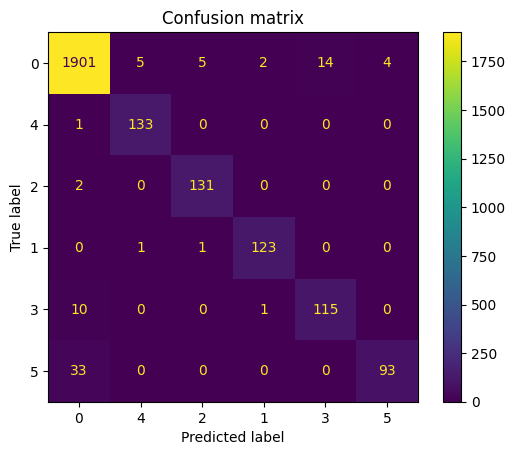

Training acc score: 0.9999028937657798
Training null acc: 0.7497572344144494

Testing acc score: 0.9693203883495146
Testing null acc: 0.7499029126213592

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1947
           1       0.99      0.96      0.97       139
           2       0.98      0.96      0.97       137
           3       0.98      0.98      0.98       126
           4       0.91      0.89      0.90       129
           5       0.74      0.96      0.83        97

    accuracy                           0.97      2575
   macro avg       0.93      0.95      0.94      2575
weighted avg       0.97      0.97      0.97      2575



In [25]:
evaluate_model(model, X_val, y_val)